In [1]:
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from torch.utils.data import DataLoader
import torch.nn.functional as func
from bs4 import BeautifulSoup
import numpy as np
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [82]:
# position = torch.arange(0, 512, dtype=torch.float).unsqueeze(1)
# print(position.shape)
# position = torch.arange(0, 512, dtype=torch.float)
# print(position.shape)
!pip install sacrebleu



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 1.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

content = '/content/drive/My Drive/ted-talks-corpus'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
test_english = 'train.en'
test_french = 'train.fr'

with open(os.path.join(content, test_english), "r") as file:
    test_english = file.readlines()

with open(os.path.join(content, test_french), "r") as file:
    test_french = file.readlines()

In [5]:
# test_english[0], test_french[0]

In [6]:
punct = string.punctuation
punct.replace('.', '')

def get_lower(text):
    return text.lower()

def remove_punctuations(text):
    return ''.join([char for char in text if char not in punct])

def tokenize(text):
    # text = text.strip()
    return word_tokenize(text)

def remove_alpha_numeric(sentence):
    # return ' '.join(word for word in tokens if word.isalpha())
    words = sentence.split()
    alphabetic_words = [word for word in words if word.isalpha()]
    return ' '.join(alphabetic_words)

def remove_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_extra_gaps(text):
    return ' '.join(text.split())

def pipeline(text):
    text = get_lower(text)
    text = remove_punctuations(text)
    tokens = tokenize(text)
    text = remove_alpha_numeric(text)
    text = remove_tags(text)
    text = remove_extra_gaps(text)
    return text

In [7]:
# test_english = [pipeline(text) for text in test_english]
# test_french = [pipeline(text) for text in test_french]

In [8]:
# test_english[0]
# test_french[0]

In [9]:
data = {}
maxi_english = 0
for sent in test_english:
    maxi_english = max(maxi_english, len(sent))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_english)

2688


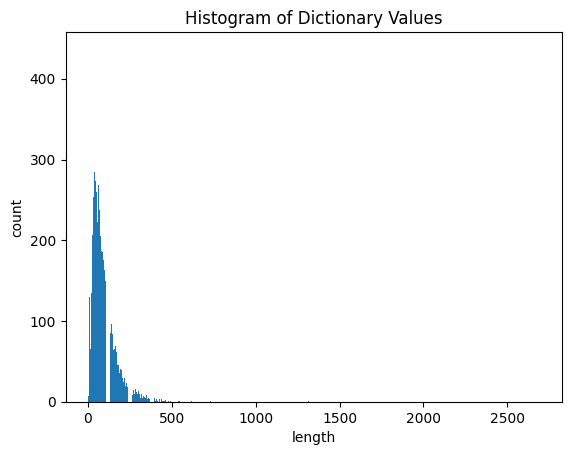

In [10]:
import matplotlib.pyplot as plt


keys = data.keys()
values = data.values()

plt.bar(keys, values)

# Add labels and a title
plt.xlabel('length')
plt.ylabel('count')
plt.title('Histogram of Dictionary Values')

# Show the plot
plt.show()


In [11]:
data = {}
maxi_french = 0
for sent in test_french:
    maxi_french = max(maxi_french, len(sent))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_french)

2967


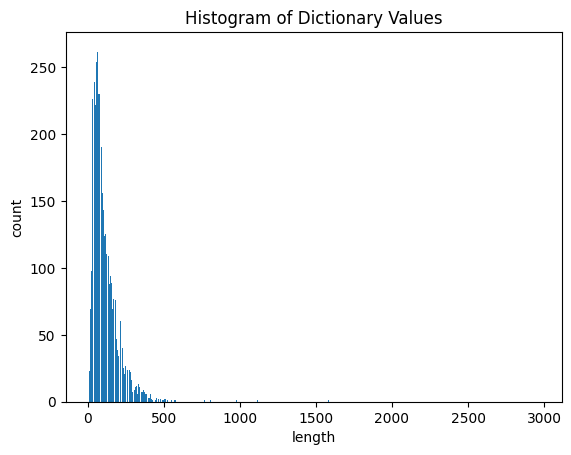

In [12]:
import matplotlib.pyplot as plt


keys = data.keys()
values = data.values()

plt.bar(keys, values)

# Add labels and a title
plt.xlabel('length')
plt.ylabel('count')
plt.title('Histogram of Dictionary Values')

# Show the plot
plt.show()


In [13]:
# df = pd.read_csv("Auguste_Maquet.txt", sep='', header=None, names="sentences")
df = pd.DataFrame({"english": test_english, "french": test_french})
print("Size : ", len(df))
df.head()

Size :  30000


,english,french
0,David Gallo: This is Bill Lange. I'm Dave Gall...,David Gallo: Voici Bill Lange. Je suis Dave Ga...
1,And we're going to tell you some stories from ...,Nous allons vous raconter quelques histoires d...
2,We've got some of the most incredible video of...,Nous avons des vidéos du Titanic parmi les plu...
3,The truth of the matter is that the Titanic --...,La vérité est que le Titanic -- même s'il cont...
4,"And the problem, I think, is that we take the ...","Le problème, je crois, est qu'on tient l'océan..."


In [14]:
rows_to_drop = []
df['english'] = df['english'].str.lower()
df['french'] = df['french'].str.lower()
limit = 300  # For example, set your desired limit

for index, row in df.iterrows():
    if len(row['english']) > limit or len(row['french']) > limit:
        rows_to_drop.append(index)

df = df.drop(rows_to_drop)

print(df)

                                                 english  \
0      david gallo: this is bill lange. i'm dave gall...   
1      and we're going to tell you some stories from ...   
2      we've got some of the most incredible video of...   
3      the truth of the matter is that the titanic --...   
4      and the problem, i think, is that we take the ...   
...                                                  ...   
29995  now, we put a lot of money into education, and...   
29996  in fact we have in the stimulus bill -- it's i...   
29997                         but i -- i'm optimistic.\n   
29998  i think people are beginning to recognize how ...   
29999     i only had time to frame those two problems.\n   

                                                  french  
0      david gallo: voici bill lange. je suis dave ga...  
1      nous allons vous raconter quelques histoires d...  
2      nous avons des vidéos du titanic parmi les plu...  
3      la vérité est que le titanic -- même

In [15]:
m1, m2 = 0, 0
for index, row in df.iterrows():
    m1 = max(m1, len(row['english']))
    m2 = max(m2, len(row['french']))
print(m1, m2)

300 300


In [16]:
word2idx_english = {'<PAD>': 0, '<UNK>': 1, '<EOS>' : 2, '<SOS>' : 3}
idx2word_english = {0 : '<PAD>', 1:'<UNK>', 2 : '<EOS>', 3 : '<SOS>'}
idx = 4
vocabulary_english = dict()
train_english = df['english']

for sent in train_english:
    for word in sent.split():
        if word not in vocabulary_english:
            vocabulary_english[word] = 1
        else:
            vocabulary_english[word] += 1

for word, val in vocabulary_english.items():
    if(val > 1) :
        word2idx_english[word] = idx
        idx2word_english[idx] = word
        idx += 1

vocab_size_english = len(idx2word_english)
vocab_size_english

17059

In [17]:
word2idx_french = {'<PAD>': 0, '<UNK>': 1, '<EOS>' : 2, '<SOS>' : 3}
idx2word_french = {0 : '<PAD>', 1:'<UNK>', 2 : '<EOS>', 3 : '<SOS>'}
idx = 4
vocabulary_french = dict()
train_french = df['french']

for sent in train_french:
    for word in sent.split():
        if word not in vocabulary_french:
            vocabulary_french[word] = 1
        else:
            vocabulary_french[word] += 1

for word, val in vocabulary_french.items():
    if(val > 1) :
        word2idx_french[word] = idx
        idx2word_french[idx] = word
        idx += 1

vocab_size_french = len(idx2word_french)
vocab_size_french

20529

In [18]:
import gensim
from gensim.models import Word2Vec
model_dim = 512

tokenized_sentences1 = [word_tokenize(sentence) for sentence in df['english']]
tokenized_sentences2 = [word_tokenize(sentence) for sentence in df['french']]

tokenized_sentences = tokenized_sentences1 + tokenized_sentences2
# tokenized_sentences.extend(tokenized_sentences2)

print(len(tokenized_sentences1), len(tokenized_sentences2), len(tokenized_sentences))

print("len", len(tokenized_sentences))
model_dim = 512
word2vec_model = Word2Vec(tokenized_sentences, vector_size=model_dim, window=5, min_count=1, sg=0)

# model.save("word2vec_model")
# model = Word2Vec.load("your_word2vec_model")

word_embedding = word2vec_model.wv['sample']

# Check the dimension of the word embedding
print(f"Embedding size of 'sample': {len(word_embedding)}")



28993 28993 57986
len 57986
Embedding size of 'sample': 512


In [19]:
len(tokenized_sentences1), len(tokenized_sentences2), len(tokenized_sentences)

(28993, 28993, 57986)

In [20]:
# word2vec_model.wv['que'], word2vec_model.wv['le']
word2vec_model = word2vec_model.wv

In [21]:
unk_vector = np.ones(model_dim)
pad_vector = np.zeros(model_dim)
sos_vector = np.random.rand(model_dim)
eos_vector = np.random.rand(model_dim)

embedding_vector = {'<PAD>':unk_vector, '<SOS>':sos_vector, '<UNK>':unk_vector, '<EOS>':eos_vector}

def get_word_embedding(word):
    if word in word2vec_model:
        return word2vec_model[word]
    elif word in embedding_vector:
        return embedding_vector[word]
    else:
        return unk_vector


embedding_matrix_english = []
for word, _ in word2idx_english.items():
    # print(word)
    embedding_matrix_english.append(get_word_embedding(word))

embedding_matrix_english = torch.tensor(embedding_matrix_english, dtype=torch.float32)
np.array(embedding_matrix_english).shape


<ipython-input-21-018049f77d3d>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embedding_matrix_english = torch.tensor(embedding_matrix_english, dtype=torch.float32)


(17059, 512)

In [22]:
unk_vector = np.ones(model_dim)
pad_vector = np.zeros(model_dim)
sos_vector = np.random.rand(model_dim)
eos_vector = np.random.rand(model_dim)

embedding_vector = {'<PAD>':unk_vector, '<SOS>':sos_vector, '<UNK>':unk_vector, '<EOS>':eos_vector}

def get_word_embedding(word):
    if word in word2vec_model:
        return word2vec_model[word]
    elif word in embedding_vector:
        return embedding_vector[word]
    else:
        return unk_vector


embedding_matrix_french = []
for word, _ in word2idx_french.items():
    # print(word)
    embedding_matrix_french.append(get_word_embedding(word))

embedding_matrix_french = torch.tensor(embedding_matrix_french, dtype=torch.float32)
np.array(embedding_matrix_french).shape


(20529, 512)

In [23]:
word2idx_english['<SOS>']

3

In [24]:
# import torch
# max_length = 300
# def custom_collate_fn(sentences):
#     # print(sentences)
#     max_length = max(len(sentence) for sentence in sentences)
#     padded_english = []
#     padded_french = []
#     for frame in df:
#         english, french = frame['english'], frame['french']
#         sos_token = [word2idx_english['<SOS>']]
#         sentence_tokens = [word2idx_english[word] if word in word2idx_english else word2idx_english['<UNK>'] for word in english]
#         pad_tokens = [word2idx_english['<PAD>']] * (max_length - len(sentence_tokens) -1)
#         eos_token = [word2idx_english['<EOS>']]
#         combined_list = sos_token + sentence_tokens + pad_tokens + eos_token
#         padded_english.append(combined_list)

#         sos_token = [word2idx_french['<SOS>']]
#         sentence_tokens = [word2idx_french[word] if word in word2idx_french else word2idx_french['<UNK>'] for word in french]
#         pad_tokens = [word2idx_french['<PAD>']] * (max_length - len(sentence_tokens))
#         eos_token = [word2idx_french['<EOS>']]
#         combined_list = sos_token + sentence_tokens + pad_tokens + eos_token
#         padded_french.append(combined_list)

#     # print(torch.tensor(padded_english).shape, torch.tensor(padded_french).shape)
#     return torch.tensor(padded_english), torch.tensor(padded_french)

import torch
from torch.utils.data import Dataset, DataLoader

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, english, french, word2idx_english, word2idx_french, max_length):
        self.english = english
        self.french = french
        self.word2idx_english = word2idx_english
        self.word2idx_french = word2idx_french
        self.max_length = max_length

    def __len__(self):
        return len(self.english)

    def __getitem__(self, idx):
        english, french = self.english[idx], self.french[idx]
        # print(english)
        # print(french)
        sos_token = [self.word2idx_english['<SOS>']]
        sentence_tokens = [self.word2idx_english[word] if word in self.word2idx_english else self.word2idx_english['<UNK>'] for word in english]
        eos_token = [self.word2idx_english['<EOS>']]
        pad_tokens = [self.word2idx_english['<PAD>']] * (self.max_length - len(sentence_tokens))
        padded_english = sos_token + sentence_tokens + eos_token + pad_tokens

        mask_eng = [1]*(len(sentence_tokens) + 1)
        mask_eng.extend([1])
        mask_eng.extend([0]*(len(pad_tokens)))

        sos_token = [self.word2idx_french['<SOS>']]
        sentence_tokens = [self.word2idx_french[word] if word in self.word2idx_french else self.word2idx_french['<UNK>'] for word in french]
        eos_token = [self.word2idx_french['<EOS>']]
        pad_tokens = [self.word2idx_french['<PAD>']] * (self.max_length - len(sentence_tokens))
        padded_french = sos_token + sentence_tokens + eos_token + pad_tokens

        mask_fr = [1]*(len(sentence_tokens) + 1)
        mask_fr.extend([1])
        mask_fr.extend([0]*(len(pad_tokens)))

        return torch.tensor(padded_english).to(torch.int64), torch.tensor(padded_french).to(torch.int64), torch.tensor(mask_eng).to(torch.int64), torch.tensor(mask_fr).to(torch.int64)



In [25]:
mask_eng = [1]*(2 + 1)
mask_eng.extend([0]*(3))
mask_eng.extend([1])
mask_eng

[1, 1, 1, 0, 0, 0, 1]

In [26]:
custom_dataset = CustomDataset(tokenized_sentences1, tokenized_sentences2, word2idx_english, word2idx_french, 302)

# Create a DataLoader using your custom dataset
batch_size = 32
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [27]:
len(df), len(dataloader), len(df)/batch_size


(28993, 907, 906.03125)

In [28]:
for a, b, c, d in dataloader:
    print(a, a.shape)
    print(b, b.shape)
    print(c, c.shape)
    print(d, d.shape)
    break

tensor([[   3,  458,   13,  ...,    0,    0,    0],
        [   3,   10,   41,  ...,    0,    0,    0],
        [   3,   58,   68,  ...,    0,    0,    0],
        ...,
        [   3,  458, 9280,  ...,    0,    0,    0],
        [   3,  155,   58,  ...,    0,    0,    0],
        [   3, 1190,  133,  ...,    0,    0,    0]]) torch.Size([32, 304])
tensor([[   3,  806, 1355,  ...,    0,    0,    0],
        [   3,   32,  141,  ...,    0,    0,    0],
        [   3,   10,  166,  ...,    0,    0,    0],
        ...,
        [   3,    7,  777,  ...,    0,    0,    0],
        [   3,   86,   94,  ...,    0,    0,    0],
        [   3,  138,   36,  ...,    0,    0,    0]]) torch.Size([32, 304])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]) torch.Size([32, 304])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [30]:
# inputs = torch.randn(10, 100, 512)
# inputs
# pos = add_positional_encoding(100, 512)
# ips, enc = pos.forward(inputs)
# print(enc)
# # print((ips-enc) == inputs)
# print(ips-enc)


In [31]:
class get_input_embeddings(nn.Module):
    def __init__(self, sentence_length, vocab_size, model_dim, drop_val=0.3):
        super(get_input_embeddings, self).__init__()
        self.vocab_size = vocab_size
        self.model_dim = model_dim
        self.sentence_length = sentence_length
        self.drop_val = drop_val
        self.weight_matrix = torch.randn(self.vocab_size, self.model_dim)
        self.positional_embeddings = add_positional_encoding(self.model_dim, self.drop_val, self.sentence_length)

    def forward(self, input):
        input = torch.matmul(input, self.weight_matrix)
        positional_encodings = self.positional_embeddings(input)
        return input + positional_encodings


In [32]:
class layer_noramlization(nn.Module):
    def __init__(self, matrix_shape, extra=1e-6):
        super(layer_noramlization, self).__init__()
        self.alpha_values = nn.Parameter(torch.ones(matrix_shape)) # mul
        self.bias_values  = nn.Parameter(torch.zeros(matrix_shape)) # add
        self.extra = extra

    def forward(self, input):
        mean = input.mean(dim=-1, keepdim=True)
        std_dev = input.std(dim=-1, keepdim=True)
        normalized_input = (input - mean)/(std_dev + self.extra)
        return self.alpha_values * normalized_input + self.bias_values

In [33]:
sequence_length, embedding_size, model_dim = 100, 512, 512

query_vector = torch.randn(embedding_size, embedding_size)
key_vector = torch.randn(embedding_size, embedding_size)
value_vector = torch.randn(embedding_size, embedding_size)


In [34]:
def softmax(matrix):
    # return torch.exp(matrix) / torch.sum(torch.exp(matrix), axis=1, keepdims=True)
    # return torch.exp(matrix) / torch.sum(torch.exp(matrix), axis=-1)
    return func.softmax(matrix, dim=-1)

In [35]:
batch_size = 10
no_of_heads = 8
reduced_head_size = model_dim//no_of_heads
reduced_head_size = torch.tensor(reduced_head_size)
sequence_length, embedding_size, model_dim, no_of_heads = 304, 512, 512, 8
model_hidden_encoding_size = 2048
max_length = 304
input = torch.randn(batch_size, sequence_length, embedding_size)
input.shape



torch.Size([10, 304, 512])

In [36]:



class self_attention(nn.Module):
    def __init__(self, head_size, sequence_length):
        super(self_attention, self).__init__()
        self.head_size = head_size
        self.sequence_length = sequence_length



    def forward(self,query_vector, key_vector, value_vector):
        # print("Before Multi", query_vector.shape, key_vector.transpose(-2, -1).shape)
        # self_attention_values = torch.matmul(query_vector, key_vector.transpose(-2, -1)) / torch.sqrt(head_size)
        self_attention_values = torch.matmul(query_vector, key_vector.transpose(-2, -1)) / torch.sqrt(self.head_size)
        # division is to stabilize the values and minimize the variance
        # if(add_mask != None):
            # self_attention_values =  add_mask_values(self_attention_values, add_mask)
        # self_attention_values =  (self_attention_values+ add_mask)
        # self_attention_values = self_attention_values + add_mask



        self_attention_values = softmax(self_attention_values)
        values = torch.matmul(self_attention_values, value_vector)
        return self_attention_values, values

In [37]:
class self_attention1(nn.Module):
    def __init__(self, head_size, sequence_length):
        super(self_attention1, self).__init__()
        self.head_size = head_size
        self.sequence_length = sequence_length



    def forward(self,query_vector, key_vector, value_vector, add_mask):
        # print("Before Multi", query_vector.shape, key_vector.transpose(-2, -1).shape)
        # self_attention_values = torch.matmul(query_vector, key_vector.transpose(-2, -1)) / torch.sqrt(head_size)
        self_attention_values = torch.matmul(query_vector, key_vector.transpose(-2, -1)) / torch.sqrt(self.head_size)
        # division is to stabilize the values and minimize the variance
        # if(add_mask != None):
            # self_attention_values =  add_mask_values(self_attention_values, add_mask)
        # self_attention_values =  (self_attention_values+ add_mask)
        self_attention_values = self_attention_values.masked_fill(add_mask == 0, float("-1e9"))

        # self_attention_values = self_attention_values + add_mask



        self_attention_values = softmax(self_attention_values)
        values = torch.matmul(self_attention_values, value_vector)
        return self_attention_values, values

In [38]:
def break_into_heads(info_matrix, sequence_length, no_of_heads, reduced_head_size):
    # print("info_matrix : ", info_matrix.shape)
    batch = info_matrix.shape[0]
    info_reshape = info_matrix.reshape(batch, sequence_length, no_of_heads, 3 * reduced_head_size)
    # print("Before premute", info_reshape.shape)
    # info_reshape = info_reshape.permute(0, 2, 1) # to make no of heads in fornt to make computation easy
    info_reshape = info_reshape.permute(0, 2, 1, 3) # to make no of heads in fornt to make computation easy
    # print("After permute : ", info_reshape.shape)
    return info_reshape.chunk(3, dim=-1) # get three matrices broken into heads

In [39]:
# kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)  # 30 x 200 x 8 x 128


In [40]:
def get_concatenated_heads(matrix):
    batch, no_of_heads, sequence_length, reduced_head_size = matrix.shape
    matrix = matrix.permute(0, 2, 1, 3)
    return matrix.reshape(batch, sequence_length, no_of_heads*reduced_head_size)

In [41]:
def get_mask_matrix(matrix):
    mask_matrix = torch.full(matrix.size(), float('-inf'))
    # print("inf values :",mask_matrix[0][1])
    return torch.triu(mask_matrix, diagonal=1)

def add_mask_values(mask_matrix, embeddings):
    return (mask_matrix + embeddings)

In [42]:
class feed_forward_network(nn.Module):
    def __init__(self, model_dim, model_hidden_encoding_size, drop_val=0.3):
        super(feed_forward_network, self).__init__()
        self.model_hidden_encoding_size = model_hidden_encoding_size
        self.model_dim = model_dim
        self.linear_layer_1 = nn.Linear(self.model_dim, self.model_hidden_encoding_size).to(device)
        self.linear_layer_2 = nn.Linear(self.model_hidden_encoding_size, self.model_dim).to(device)
        self.dropout = nn.Dropout(drop_val).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, input):
        input = self.linear_layer_1(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.linear_layer_2(input)
        return input


In [43]:
class MultiheadAttentionEncoder(nn.Module):

    def __init__(self, sequence_length, embedding_size, model_dim, no_of_heads, model_hidden_encoding_size, drop_val=0.3, mask=None):
        super(MultiheadAttentionEncoder, self).__init__()
        self.sequence_length = sequence_length
        self.embedding_size = embedding_size
        self.model_dim = model_dim
        # self.batch_size = batch_size
        self.no_of_heads = no_of_heads
        self.reduced_head_size = torch.tensor(self.model_dim//self.no_of_heads)
        self.make_matrix = nn.Linear(self.model_dim, 3*self.model_dim)
        # self.mask = torch.tril(torch.ones( (sequence_length, sequence_length) ))
        # self.mask[self.mask == 0] = -torch.tensor(float("inf"))
        # self.mask[self.mask == 1] = 0
        # self.mask = self.mask.to(device)
        self.model_hidden_encoding_size = model_hidden_encoding_size
        self.hidden_weights_1 = nn.Linear(self.model_dim, self.model_hidden_encoding_size)
        self.hidden_weights_2 = nn.Linear(self.model_hidden_encoding_size, self.model_dim)
        self.self_attention = self_attention1(self.reduced_head_size, self.sequence_length)
        self.dropout = nn.Dropout(drop_val)

    def forward(self, input, mask):
        input = self.make_matrix(input)
        # query_vector, key_vector, value_vector = break_into_heads(input, self.batch_size, self.sequence_length, self.no_of_heads, self.reduced_head_size)
        query_vector, key_vector, value_vector = break_into_heads(input, self.sequence_length, self.no_of_heads, self.reduced_head_size)
        # print("After break", query_vector.shape, key_vector.shape, value_vector.shape)
        # self_attention_values, values = self.self_attention(query_vector, key_vector, value_vector, self.mask)
        # self_attention_values, values = self.self_attention(query_vector, key_vector, value_vector, self.mask)
        self_attention_values, values = self.self_attention(query_vector, key_vector, value_vector, mask)
        # self_attention_values, values = self.self_attention(query_vector, key_vector, value_vector, mask)

        # print("before concat : ", values.shape)
        values = get_concatenated_heads(values)
        # print("after concat : ", values.shape)
        values = torch.relu(self.hidden_weights_1(values))
        values = self.dropout(values)
        values = self.hidden_weights_2(values)
        return values

In [44]:
# model = MultiheadAttentionEncoder(304, embedding_size, model_dim, no_of_heads, model_hidden_encoding_size, 0.3, mask=False)
# inputs = torch.randn(32, sequence_length, embedding_size)
# out = model.forward(inputs)
# out.shape

In [45]:
embedding_matrix_english.shape

torch.Size([17059, 512])

In [46]:
# inputs = torch.randn(sequence_length, embedding_size)
class EncoderLayer(nn.Module):
    def __init__(self,embedding_matrix_english, mask=None, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3):
        super(EncoderLayer, self).__init__()
        self.multi_attention = MultiheadAttentionEncoder(304, embedding_size, model_dim, no_of_heads, model_hidden_encoding_size, 0.3, mask=False)

        self.feed_forward = feed_forward_network(model_dim, model_hidden_encoding_size, drop_val)
        self.normalize_1 = layer_noramlization(matrix_shape = [model_dim])
        self.normalize_2 = layer_noramlization(matrix_shape = [model_dim])
        self.dropout_1 = nn.Dropout(drop_val)
        self.dropout_2 = nn.Dropout(drop_val)
        self.embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix_english), freeze=True)

    def forward(self, input, mask):
        attention_out = self.multi_attention(input, mask)
        attention_out = self.dropout_1(attention_out)
        input = attention_out + input
        input = self.normalize_1(input)

        feed_forward_out = self.feed_forward(input)
        input = input + feed_forward_out
        input = self.normalize_2(input)

        return input

In [47]:
class transformer_encoder_stacked(nn.Module):
    def __init__(self, embedding_matrix_english, N=2, mask=False, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3):
        super(transformer_encoder_stacked, self).__init__()
        self.layers = nn.Sequential(*[EncoderLayer(embedding_matrix_english, mask=False, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3).to(device)
                            for _ in range(N)]).to(device)

    def forward(self, input, mask):
        for layer in self.layers:
            return layer(input, mask)


In [48]:
temp = torch.randn(32, 304)
src_mask = (temp != 0).unsqueeze(1).unsqueeze(2).to(device)
src_mask.shape

torch.Size([32, 1, 1, 304])

In [49]:
transformer_encoder = transformer_encoder_stacked(embedding_matrix_english, N=2, mask=False, sequence_length=100, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3).to(device)
i = torch.randn(32, 304, 512).to(device)
ans = transformer_encoder(i, src_mask)
ans

<ipython-input-46-7c8050150331>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix_english), freeze=True)


tensor([[[ 4.7335e-01, -2.2384e-01, -7.9985e-01,  ...,  1.0175e-01,
          -1.0835e-03,  2.6114e-02],
         [-5.3465e-01, -8.9905e-01, -2.4780e-01,  ...,  5.0443e-01,
          -5.2063e-01,  1.9102e+00],
         [ 6.5072e-01,  9.4348e-02,  6.3346e-01,  ..., -1.8634e+00,
          -6.4433e-01,  3.7199e-01],
         ...,
         [ 1.9164e-01,  6.8952e-01, -7.1508e-01,  ..., -4.0078e-01,
          -1.9544e+00, -2.6346e+00],
         [ 6.2374e-01, -5.0665e-01,  9.8409e-01,  ...,  2.4189e-01,
          -1.6579e-01,  1.0151e+00],
         [-7.1633e-02,  8.0029e-01,  1.8251e-01,  ..., -2.3073e-01,
          -1.4369e-01,  5.8926e-01]],

        [[ 4.8843e-01,  1.1288e+00, -1.1724e+00,  ...,  1.1544e-01,
           4.5573e-01, -4.7471e-01],
         [-3.6419e-01,  2.1591e+00,  2.0248e+00,  ...,  2.1053e-01,
          -6.4265e-01, -2.4636e-01],
         [ 2.0830e+00,  5.7162e-01,  2.0088e-01,  ..., -1.0024e+00,
          -7.1302e-02, -7.0780e-01],
         ...,
         [-1.7501e+00, -1

In [50]:
# ans.shape

In [51]:
total_params = sum(p.numel() for p in transformer_encoder.parameters())
print(f"Total parameters in the transformer_encoder: {total_params}")

Total parameters in the transformer_encoder: 21149696


In [52]:
def break_into_heads_decoder(kv_matrix, sequence_length, no_of_heads, reduced_head_size):
    batch = kv_matrix.shape[0]
    # print("inside break_into_heads_decoder : ", kv_matrix.shape)
    kv_reshape = kv_matrix.reshape(batch, sequence_length, no_of_heads, 2 * reduced_head_size)
    kv_reshape = kv_reshape.permute(0, 2, 1, 3)
    return kv_reshape.chunk(2, dim=-1) # get two matrices broken into heads

In [53]:
class MaskedMultiheadAttentionDecoder(nn.Module):

        # self.self_attention = self_attention(self.reduced_head_size, self.sequence_length)
        # self_attention_values, values = self_attention(query_vector, key_vector, value_vector, self.mask)

    def __init__(self, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=2048, drop_val=0.3):
        super(MaskedMultiheadAttentionDecoder, self).__init__()
        self.sequence_length = sequence_length
        self.embedding_size = embedding_size
        self.model_dim = model_dim
        # self.batch_size = batch_size
        self.no_of_heads = no_of_heads
        self.reduced_head_size = torch.tensor(self.model_dim//self.no_of_heads)
        self.make_matrix = nn.Linear(self.model_dim, 3*self.model_dim)
        self.mask = torch.full([self.sequence_length, self.sequence_length] , float('-inf'))
        self.mask = torch.triu(self.mask, diagonal=1)
        self.mask = self.mask.to(device)
        self.model_hidden_encoding_size = model_hidden_encoding_size
        self.hidden_weights_1 = nn.Linear(self.model_dim, self.model_hidden_encoding_size)
        self.hidden_weights_2 = nn.Linear(self.model_hidden_encoding_size, self.model_dim)
        self.self_attention1 = self_attention1(self.reduced_head_size, self.sequence_length)
        self.dropout = nn.Dropout(drop_val)

    def forward(self, input):
        input = self.make_matrix(input)
        # print("entered : ", input.shape)
        # query_vector, key_vector, value_vector = break_into_heads(input, self.batch_size, self.sequence_length, self.no_of_heads, self.reduced_head_size)
        query_vector, key_vector, value_vector = break_into_heads(input, self.sequence_length, self.no_of_heads, self.reduced_head_size)
        # print("After break", query_vector.shape, key_vector.shape, value_vector.shape)
        self_attention_values, values = self.self_attention1(query_vector, key_vector, value_vector, self.mask)
        # self_attention_values, values = self_attention(query_vector, key_vector, self.reduced_head_size, self.sequence_length, value_vector, self.mask)
        # print("before concat : ", values.shape)
        values = get_concatenated_heads(values)
        # print("after concat : ", values.shape)
        values = torch.relu(self.hidden_weights_1(values))
        values = self.dropout(values)
        values = self.hidden_weights_2(values)
        return values

In [54]:

class CrosMultiheadAttentionDecoder(nn.Module):
      #  self.self_attention = self_attention(self.reduced_head_size, self.sequence_length)
        # self_attention_values, values = self_attention(query_vector, key_vector, value_vector, self.mask)

    def __init__(self, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=2048, drop_val=0.3):
        super(CrosMultiheadAttentionDecoder, self).__init__()
        self.sequence_length = sequence_length
        self.embedding_size = embedding_size
        self.model_dim = model_dim
        # self.batch_size = batch_size
        self.no_of_heads = no_of_heads
        self.reduced_head_size = torch.tensor(self.model_dim//self.no_of_heads)
        self.make_matrix = nn.Linear(self.model_dim, 2*self.model_dim)
        # self.mask = torch.zeros(self.sequence_length, self.sequence_length)
        # self.mask = self.mask.to(device)
        self.query_vector = nn.Linear(self.model_dim , self.model_dim)
        self.model_hidden_encoding_size = model_hidden_encoding_size
        self.hidden_weights_1 = nn.Linear(self.model_dim, self.model_hidden_encoding_size)
        self.self_attention1 = self_attention1(self.reduced_head_size, self.sequence_length)
        self.hidden_weights_2 = nn.Linear(self.model_hidden_encoding_size, self.model_dim)
        self.dropout = nn.Dropout(drop_val)

    def forward(self, input_eng, input_french, mask):
        input = self.make_matrix(input_eng)
        # print("key-val : ", input.shape)
        key_vector, value_vector = break_into_heads_decoder(input, self.sequence_length, self.no_of_heads, self.reduced_head_size)
        batch = key_vector.shape[0]
        query_vector = self.query_vector(input_french)
        query_vector = query_vector.reshape(batch, self.no_of_heads, self.sequence_length, self.reduced_head_size)
        self_attention_values, values = self.self_attention1(query_vector, key_vector, value_vector, mask)
        # print(query_vector.shape, key_vector.shape, value_vector.shape)
        # self_attention_values, values = self_attention(query_vector, key_vector, self.reduced_head_size, self.sequence_length, value_vector)
        # print(self_attention_values)
        # print("before concat : ", values.shape)
        values = get_concatenated_heads(values)
        # print("after concat : ", values.shape)
        values = torch.relu(self.hidden_weights_1(values))
        values = self.dropout(values)
        values = self.hidden_weights_2(values)
        return values

In [55]:
obj = CrosMultiheadAttentionDecoder(sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=2048, drop_val=0.3).to(device)
# mask = torch.full([sentence_length=100, sentence_length=100] , float('-inf'))
mask = torch.full([304, 304] , float('-inf'))
mask = torch.triu(mask, diagonal=1).to(device)
inputs = torch.randn(32, 304, 512).to(device)
val = obj(inputs, inputs, src_mask)
val.shape

torch.Size([32, 304, 512])

In [56]:
# inputs = torch.randn(sequence_length, embedding_size)
class DecoderLayer(nn.Module):
    def __init__(self, embedding_matrix_english, embedding_matrix_french, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3):
        super(DecoderLayer, self).__init__()
        self.mask = torch.full([100, 100] , float('-inf'))
        self.mask = torch.triu(self.mask, diagonal=1)
        self.masked_multi_attention = MaskedMultiheadAttentionDecoder(sequence_length, embedding_size, model_dim, no_of_heads, model_hidden_encoding_size, drop_val)
        self.cross_multi_attention = CrosMultiheadAttentionDecoder(sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=2048, drop_val=0.3)
        self.feed_forward = feed_forward_network(model_dim, model_hidden_encoding_size, drop_val)

        self.normalize_1 = layer_noramlization(matrix_shape = [model_dim])
        self.normalize_2 = layer_noramlization(matrix_shape = [model_dim])
        self.normalize_3 = layer_noramlization(matrix_shape = [model_dim])

        self.dropout_1 = nn.Dropout(drop_val)
        self.dropout_2 = nn.Dropout(drop_val-0.1)
        self.dropout_3 = nn.Dropout(drop_val+0.1)
        # print(self.mask)

    def forward(self, input_x, input_y, mask):
        # print("part 1")
        input = input_y
        attention_out = self.masked_multi_attention(input_y)
        attention_out = self.dropout_1(attention_out)
        input_y = attention_out + input_y
        input_y = self.normalize_1(input_y)
        # print(input_y.shape)

        # print("part 2")
        input = input_y
        # print(input_x.shape, input_y.shape)
        attention_out = self.cross_multi_attention(input_x, input_y, mask)
        attention_out = self.dropout_2(attention_out)
        input_y = attention_out + input_y
        input_y = self.normalize_2(input_y)
        # print(input_y.shape)

        # print("part 3")
        input = input_y
        feed_forward_out = self.feed_forward(input_y)
        feed_forward_out = self.dropout_2(feed_forward_out)
        input_y = attention_out + input_y
        input_y = self.normalize_3(input_y)

        return input_y


# transformer_encoder

In [57]:
# torch.randn(sequence_length, embedding_size).shape

In [58]:
# decoder = DecoderLayer(sequence_length=100, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3)
# x = torch.randn(sequence_length, embedding_size)
# y = torch.randn(sequence_length, embedding_size)
# out = decoder(x, y)
# print(out.shape)

In [59]:
class transformer_decoder_stacked(nn.Module):
    def __init__(self, embedding_matrix_english, embedding_matrix_french, N=2, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3):
        super(transformer_decoder_stacked, self).__init__()
        self.layers = nn.Sequential(*[DecoderLayer(embedding_matrix_english, embedding_matrix_french, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3).to(device)
                            for _ in range(N)]).to(device)

    def forward(self, input_x, input_y, mask):
        for layer in self.layers:
            input_y = layer(input_x, input_y, mask)
        return input_y


In [60]:
x = torch.randn(32, 304, embedding_size).to(device)
y = torch.randn(32, 304, embedding_size).to(device)
src_mask = src_mask.to(device)
transformer_decoder = transformer_decoder_stacked(embedding_matrix_english, embedding_matrix_french, N=2, sequence_length=304, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3).to(device)

ans = transformer_decoder(x, y, src_mask)
print(ans.shape)

torch.Size([32, 304, 512])


In [61]:
total_params = sum(p.numel() for p in transformer_decoder.parameters())
print(f"Total parameters in the transformer_encoder: {total_params}")

Total parameters in the transformer_encoder: 9458688


In [62]:
# import torch.nn as nn
# import torch
# import math

# class get_input_embeddings(nn.Module):
#     def __init__(self, sentence_length, embedding_matrix_english, model_dim, drop_val=0.3):
#         super(get_input_embeddings, self).__init__()
#         self.model_dim = model_dim
#         self.sentence_length = sentence_length
#         self.drop_val = drop_val
#         self.weight_matrix = embedding_matrix_english
#         self.positional_embeddings = add_positional_encoding(self.model_dim, self.drop_val, self.sentence_length)

#     def forward(self, input):
#         input = torch.matmul(input, self.weight_matrix)
#         positional_encodings = self.positional_embeddings(input)
#         return input + positional_encodings

# get_embeddings = get_input_embeddings(max_length, embedding_matrix_english, model_dim)
# final_embeddings = get_embeddings()


In [63]:
# class add_positional_encoding(nn.Module):
#     def __init__(self, max_sequence_length, model_dim, dropout_prob=0.3):
#         super(add_positional_encoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout_prob).to(device)

#         position = torch.arange(0, max_sequence_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, model_dim, 2, dtype=torch.float) * -(math.log(10000.0) / model_dim))
#         positional_encodings = torch.zeros(max_sequence_length, model_dim)

#         positional_encodings[:, 0::2] = torch.sin(position * div_term)
#         positional_encodings[:, 1::2] = torch.cos(position * div_term)
#         self.register_buffer("positional_encodings", positional_encodings)

#     def forward(self, input):
#         # print("GET POSN SHAPE", input.shape, self.positional_encodings.shape)
#         max_sequence_length = input.size(1)
#         positional_encodings = self.positional_encodings[:max_sequence_length, :].unsqueeze(0).to(device)
#         input_with_position = input + positional_encodings
#         return self.dropout(input_with_position).to(device)


In [64]:
import torch
import torch.nn as nn
import math

class add_positional_encoding(nn.Module):
    def __init__(self, max_sequence_length, model_dim, dropout_prob=0.3):
        super(add_positional_encoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(0, max_sequence_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2, dtype=torch.float) * -(math.log(10000.0) / model_dim))
        positional_encodings = torch.zeros(max_sequence_length, model_dim)

        positional_encodings[:, 0::2] = torch.sin(position * div_term)
        positional_encodings[:, 1::2] = torch.cos(position * div_term)
        self.positional_encodings = positional_encodings.to(device)
        # self.positional_encodings = nn.Parameter(positional_encodings, requires_grad=False)

    def forward(self, input):
        # print("adding : ", input.shape, self.positional_encodings.shape)
        input_with_position = input + self.positional_encodings
        return self.dropout(input_with_position)


In [65]:
max_length = 304


class Transformer(nn.Module):
    def __init__(self,embedding_matrix_english=embedding_matrix_english, embedding_matrix_french=embedding_matrix_french, vocab_size_french=vocab_size_french, N=2, sequence_length=max_length, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3):
        super().__init__()
        self.encoder =  transformer_encoder_stacked(embedding_matrix_english, N=2, mask=False, sequence_length=100, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3)
        self.decoder = transformer_decoder_stacked(embedding_matrix_english, embedding_matrix_french, N=2, sequence_length=100, embedding_size=512, model_dim=512, no_of_heads = 8, model_hidden_encoding_size=512, drop_val=0.3)
        self.linear = nn.Linear(model_dim, vocab_size_french)
        self.embedding_matrix_english = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix_english), freeze=False)
        self.embedding_matrix_french = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix_french), freeze=False)
        self.add_positional_encoding = add_positional_encoding(sequence_length, model_dim, dropout_prob=0.3)

    def forward(self, x, y, mask):
        # print(x.shape, y.shape)
        x = x.to(torch.int64)
        y = y.to(torch.int64)
        # print("INPUTS SHAPE : ", x.shape, y.shape)
        x = self.embedding_matrix_english(x)
        y = self.embedding_matrix_french(y)

        # print("INPUTS SHAPE : ", x.shape, y.shape)

        x = self.add_positional_encoding(x).to(device)

        # print(x.shape)
        y = self.add_positional_encoding(y).to(device)

        # print(x.shape, y.shape)
        # print(x.dtype, y.dtype)
        x = self.encoder(x, mask)
        # print("ENCODER DONE", "="*30)
        out = self.decoder(x, y, mask)
        # print("DECODER DONE", "="*30)
        out = self.linear(out)
        # print("FINAL DONE", "="*30)

        return out

In [66]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
embedding_dim = 100
hidden_dim = 50
num_layers = 2
batch_size_lstm = 32
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01
model = Transformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


<ipython-input-46-7c8050150331>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix_english), freeze=True)
<ipython-input-65-33a2cb2a7a31>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding_matrix_english = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix_english), freeze=False)
<ipython-input-65-33a2cb2a7a31>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding_matrix_french = nn.Embedding.from_pretrained(torch.tensor(embed

In [67]:


# model

In [68]:

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the transformer_encoder: {total_params}")

Total parameters in the transformer_encoder: 60384817


In [69]:
num_epochs = 5
path = "/content/drive/My Drive/ass3_model1.pth"
prev_loss = 1000
from tqdm import tqdm

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    count=0
    mini = 100

    for (batch_input_embeddings, batch_target_embeddings, mask_eng, mask_fr) in dataloader:

        batch_input_embeddings = batch_input_embeddings.to(device)
        batch_target_embeddings = batch_target_embeddings.to(device)
        mask_eng = mask_eng.to(device)
        # print("INPUTTING : ", batch_input_embeddings.shape, batch_target_embeddings.shape, batch_input_embeddings.dtype,  batch_target_embeddings.dtype)

        optimizer.zero_grad()
        mask = (mask_eng != 0).unsqueeze(1).unsqueeze(2)

        outputs = model(batch_input_embeddings, batch_target_embeddings, mask)
        # Flatten the output tensor
        outputs = outputs.view(-1, vocab_size_french)
        batch_target_embeddings = batch_target_embeddings.view(-1)
        loss = nn.CrossEntropyLoss()(outputs, batch_target_embeddings)

        # print("Output : ", outputs.shape, batch_target_embeddings.shape)
        # loss = loss_function(outputs, batch_target_embeddings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    if(prev_loss > total_loss):
        torch.save(model.state_dict(), path)
    prev_loss = total_loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader)}')

 20%|██        | 1/5 [07:33<30:12, 453.18s/it]

Epoch [1/5], Loss: 0.7096073118170935


 40%|████      | 2/5 [15:08<22:43, 454.55s/it]

Epoch [2/5], Loss: 0.6742060397399431


 60%|██████    | 3/5 [22:43<15:08, 454.49s/it]

Epoch [3/5], Loss: 0.659109830790607


 80%|████████  | 4/5 [30:22<07:36, 456.59s/it]

Epoch [4/5], Loss: 0.6558970278652658


100%|██████████| 5/5 [38:01<00:00, 456.28s/it]

Epoch [5/5], Loss: 0.654511099810637


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
embedding_dim = 100
hidden_dim = 50
num_layers = 2
batch_size_lstm = 32
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
model = Transformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [ ]:
num_epochs = 5
path = "/content/drive/My Drive/ass3_model.pth"
prev_loss = 1000
from tqdm import tqdm

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    count=0
    mini = 100

    for (batch_input_embeddings, batch_target_embeddings) in dataloader:
        batch_input_embeddings = batch_input_embeddings.to(device)
        batch_target_embeddings = batch_target_embeddings.to(device)
        # print("INPUTTING : ", batch_input_embeddings.shape, batch_target_embeddings.shape, batch_input_embeddings.dtype,  batch_target_embeddings.dtype)


        optimizer.zero_grad()
        outputs = model(batch_input_embeddings, batch_target_embeddings)
        # Flatten the output tensor
        outputs = outputs.view(-1, 20529)
        batch_target_embeddings = batch_target_embeddings.view(-1)
        loss = nn.CrossEntropyLoss()(outputs, batch_target_embeddings)

        # print("Output : ", outputs.shape, batch_target_embeddings.shape)
        # loss = loss_function(outputs, batch_target_embeddings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    if(prev_loss > total_loss):
        torch.save(model.state_dict(), path)
    prev_loss = total_loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader)}')

 20%|██        | 1/5 [07:33<30:12, 453.18s/it]

Epoch [1/5], Loss: 0.7096073118170935


 40%|████      | 2/5 [15:08<22:43, 454.55s/it]

Epoch [2/5], Loss: 0.6742060397399431


 60%|██████    | 3/5 [22:43<15:08, 454.49s/it]

Epoch [3/5], Loss: 0.659109830790607


 80%|████████  | 4/5 [30:22<07:36, 456.59s/it]

Epoch [4/5], Loss: 0.6558970278652658


100%|██████████| 5/5 [38:01<00:00, 456.28s/it]

Epoch [5/5], Loss: 0.654511099810637


In [70]:
# path = "/content/drive/My Drive/ass3_model.pth"
# torch.save(model.state_dict(), path)

In [92]:
import sacrebleu
from sacrebleu import sentence_bleu
targets = []
dtranslated = []
blue_scores = []
def calculate_avg_score_bleu(bleu_scores):
    total_score = sum(score for _, _, score in bleu_scores)
    return total_score / len(bleu_scores)

for (batch_input_embeddings, batch_target_embeddings, mask_eng, mask_fr) in dataloader:

    batch_input_embeddings = batch_input_embeddings.to(device)
    batch_target_embeddings = batch_target_embeddings.to(device)
    mask_eng = mask_eng.to(device)
    # print("INPUTTING : ", batch_input_embeddings.shape, batch_target_embeddings.shape, batch_input_embeddings.dtype,  batch_target_embeddings.dtype)

    optimizer.zero_grad()
    mask = (mask_eng != 0).unsqueeze(1).unsqueeze(2)

    outputs = model(batch_input_embeddings, batch_target_embeddings, mask)
    print(outputs.shape, batch_target_embeddings.shape)



    for i in range(32):
        true_french = ""
        temp_fr = ""
        for j in range(max_length):
            word_index = batch_target_embeddings[i][j].item()
            true_french += idx2word_french[word_index] + " "

            softmaxed_list = np.exp(outputs[i][j].cpu().detach().numpy()) / np.sum(np.exp(outputs[i][j].cpu().detach().numpy()), axis=0)
            max_index = np.argmax(softmaxed_list)
            # Convert the tensor to a scalar using .item()
            word_index = max_index.item()
            temp_fr += idx2word_french[word_index] + " "

        bleu = sentence_bleu(true_french, temp_fr)
        targets.append(true_french)
        dtranslated.append(temp_fr)
        blue_scores.append(bleu)


for i in range(len(targets)):
    print("Target:", targets[i])
    print("Translated:", dtranslated[i])
    print("BLUE score:", blue_scores[i])

Streaming output truncated to the last 5000 lines.
Target: Pas de jalousie, pas de Proust. Bien sûr, je sais que c'est à la mode de dire que Proust détient la réponse à tout. Mais dans le cas de la jalousie, c'est un peu vrai.
Translated: Ce n ' est pas , pas . Et je veux dire , je pense que je pense que c ' est que le , mais ce que le , mais il est vraiment , il est pas , c ' est , il est pas .
BLUE score: 2.8310852916881273

Target: Et ça, évidemment, c'est parce que vous ne pouvez pas tromper tout le monde, tout le temps, généralement.
Translated: Et ce que , c ' est , parce que vous ne pouvez pas les gens ne pas les gens de la plupart des gens ,
BLUE score: 20.22202784230022

Target: Alors oui, la moitié des jeunes dans la vingtaine sont sans emploi ou sous-employés.
Translated: Donc , les , les sont ou ou ou ou ou des .
BLUE score: 3.6672995332980713

Target: Dans votre cuisine, le sol a été pavé d'une route de briques jaunes. et sortant de votre four, viennent vers vous Dorothy, 

In [ ]:
with open("train_bleu_scores_varun.txt", "w") as file:
    for i in range(len(targets)):
        file.write(f"Real French : {targets[i]}")
        file.write(f"Predicted French : {dtranslated[i]}")
        file.write(f"Bleu Score : {blue_scores[i]:.4f}\n")